# Behavioural Cloning

This project is an exercise in end-to-end deep learning. 
We train a convolutional neural network regression model to drive around a simulated race track. The model outputs appropriate steerings angles, its sole responsibility, given images of the track. 

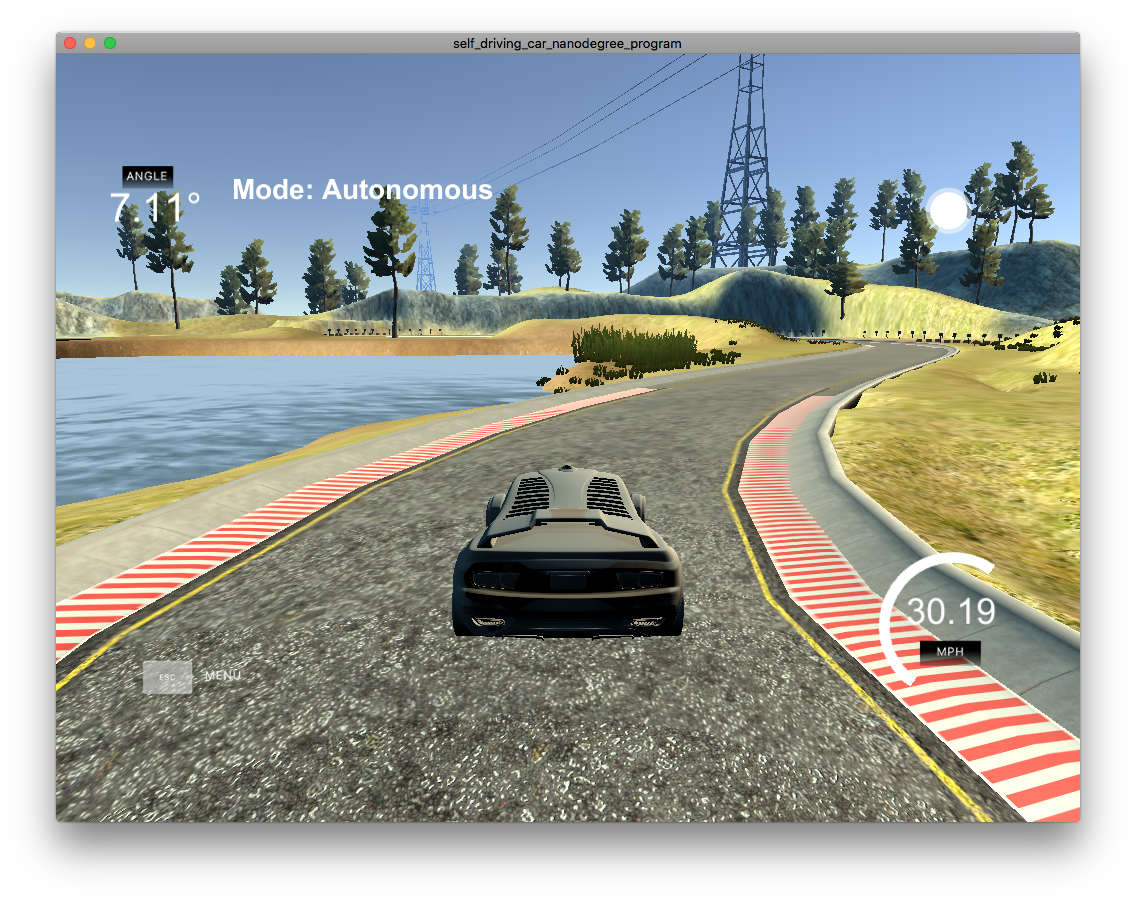

## Library Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn.utils import shuffle

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, GaussianNoise
from keras.layers.convolutional import Conv2D
from keras.regularizers import l2
from keras.layers.pooling import AvgPool2D
from keras import backend as K

## Data Collection
- Data collection was done by recording one clockwise and one counter-clockwise circuit around the first track. This is to get roughly the same amount of right and left turn samples.
- The 'Simple' graphics quality setting was used for shadows to rendered and included. 

## Dataset Exploration
The recording produced a folder named `IMG` containing 10695 `.jpg` images and a single `.csv` data file.

### Images
- Each image is taken from the first-person perspective of the car.
- Each is taken from 1 of 3 laterally offset (and possibly slightly angeled) forward facing cameras.
- Images are mostly clean - no simulator user interface element, or any other part of the screen, is contained. 
- The hood is visible at the bottom on every image - it's ~32 pixels from the bottom, at the extrema, in a 'center' image.
- The sky is present at the top of every image - it appears ~96 pixels from the bottom on a mostly level part of the track.
- Images are all 320x160 pixels, 8bit RGB, JPEGs.
- Filesize varies a bit: 14-18Kb, probably due to JPEG compression.
- Filenames (e.g `center_2018_08_08_04_36_29_623.jpg`) consists of a camera tag and a timestamp.
- The filename prefix is a tag (one of possible three:`left`, `center`, `right`) corresponding to the lateral offset of the camera from which the image was taken.
- The filname infix is an underscore seperated timestamp: `YEAR_MONTH_DAY_HOUR_MINUTE_SECOND_MILLISECOND`.
- There are always exactly 3 images with the same exact timestamp, one for each camera offset tag. 
- Sequential timestamps differ by ~80ms, which implies sampling at a rate of ~12.5 Frames per second (e.g `center_2018_08_08_04_35_12_890.jpg`, `center_2018_08_08_04_35_12_969.jpg`). 

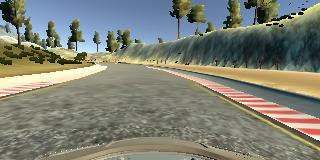
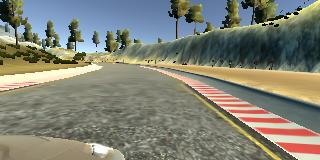
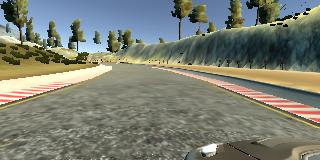

### Sensor Data
- The file `driving_log.csv` contains sensor data samples (steering angle, throttle, brakes, speed) with their corresponding image paths. 
- It's a plain text file. 
- The data is organized as a table: rows are separated by newlines, columns are separated by commas.
- Each row contains absolute paths for the 3 images, followed by the values for steering angle, throttle, brakes, speed. 

In [536]:
# load and display the data
headers = ['center', 'left', 'right', 'angle', 'throttle', 'brake', 'speed' ]
data = pd.read_csv('./driving_log.csv',names=headers)
data

,center,left,right,angle,throttle,brake,speed
0,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,0.000000,0.000000,0,8.360088
1,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,0.000000,0.000000,0,8.293460
2,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,0.000000,0.000000,0,8.243561
3,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,0.000000,0.241800,0,8.318796
4,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,0.000000,0.483495,0,8.625457
5,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,0.000000,0.723639,0,9.146161
6,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,0.000000,0.965436,0,9.902363
7,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,-0.200000,1.000000,0,10.775380
8,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,-0.320265,1.000000,0,11.716260
9,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,/Users/roman/CarND-Behavioral-Cloning-P3/examp...,-0.119952,1.000000,0,12.034900


#### Steering Angles
- The overwhelming majority of values are zero, or very near to zero.
- The steering angle data is very jittery. Probably due to keyboard input.

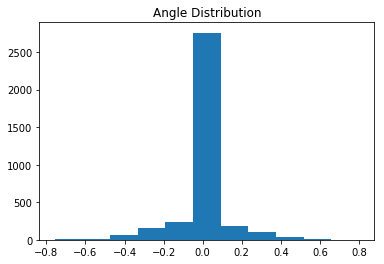

In [504]:
plt.title('Angle Distribution')
hist = plt.hist(data['angle'], bins=11)

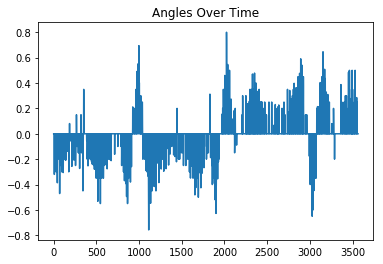

In [537]:
plt.title('Angles Over Time')
plt.plot(data.angle)

#### Brake and Throttle
Brake and Throttle data is pretty much constant.

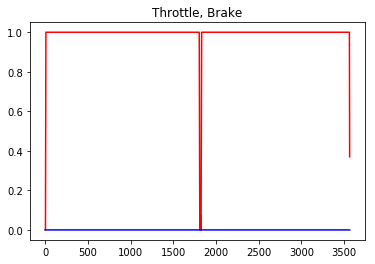

In [495]:
plt.title('Throttle, Brake')
plt.plot(data.throttle, color ='r')
plt.plot(data.brake, color = 'b')

#### Speed
Speed does seem to be strongly correlated with steering. The relationship is probably causal: the simulator is programmed to drop the speed while the car turns. 

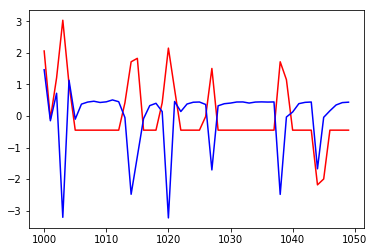

In [518]:
angle, speed = data.angle[1000:1050], data.speed[1000:1050]
angle, speed = (angle-np.mean(angle))/np.std(angle), (speed-np.mean(speed))/np.std(speed)
plt.plot(angle, color='r');plt.plot(speed, color='b')

## Data Selection
1. Altough there are many ways to make use of the 3 images (e.g combine to create a depthmap, stitch to increase FOV, etc) we'll discard all but the center images for simplicity.
2. Throttle and brake usage is pretty much contant and uncorrelated with steering, hence we'll discard these outright. Speed does seem to be correlated, but we'll discard it too for the sake of simplicity.

In [167]:
# delete left and right images
!rm -f left*
!rm -f right*

In [796]:
headers = ['center', 'left', 'right', 'angle', 'throttle', 'brake', 'speed' ]
data = pd.read_csv('./driving_log.csv',names=headers)
data = data.drop(columns=['left', 'right', 'throttle', 'brake', 'speed' ])

## Data Preparation

### Noise Reduction
We've observed the steering data is very jittery. We'll make use of the temporal locality inherent in the collection method to smooth out the steering data over a few seconds. We'll apply a Gaussian blur filter to smooth out the data (an averaging filter will do poorly in this case since it doesn't interpolate in regard to temporal distance).

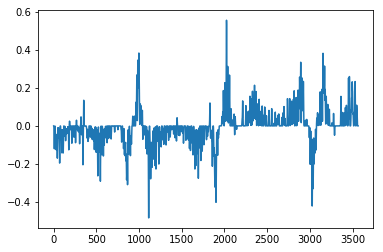

In [797]:
ker = np.exp(-np.arange(-12,13)**2/8.)/np.sqrt(8.*np.pi)
ker = ker/np.sum(ker)
data.angle = np.convolve(data.angle, ker, mode='same')
plt.plot(data.angle)

### Imputation
The overwhelming majority of samples have a steering angle of zero, or close to zero. Training a model on this data directly is not practical since it will be very biased. 
We'll re-balance the dataset by fabricating samples from the existing data.

In [798]:
data.angle += np.random.uniform(-0.02,0.02,len(data))
data.angle = data.angle.round(decimals=1)
data.angle.value_counts()
uniq = data.angle.unique()
cmax = np.max(data.angle.value_counts())
for u in uniq:
    rows = data[data.angle==u]
    data = data.append(rows.iloc[np.arange(cmax-len(rows))%len(rows)])

(27456, 2)
(12,)


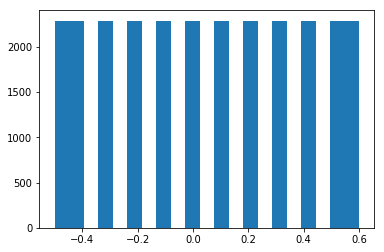

In [799]:
print(data.shape)
print(data.angle.value_counts().shape)
hist = plt.hist(data.angle,bins=21)

### Randomize and Save

In [800]:
data.center = data.center.str.replace('/Users/roman/CarND-Behavioral-Cloning-P3/examples','.')
data = shuffle(data)
data.to_csv('./clean.csv')

## Preprocessing

### Dimensionality Reduction
We'll start by reducing to a single color channel. The lane markings and road/offroad seperation are clearly discernible to a human eye on both tracks. Therefore, the default OpenCV color to grayscale conversion algorithm is probably a good choice in most situations. 


However, we'll later perform edge detection and binarize the image, therefore this step is redundant.

### Subsampling
1. We'll crop the sky and hood areas since they're mostly invariant and don't contribute to the prediction task anyway.
2. We'll resize the image somewhat to reduce computation requirements.

(32, 128)

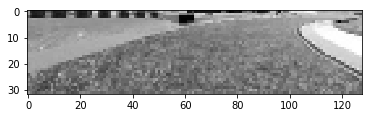

In [829]:
img = cv2.imread(data.center[0], cv2.IMREAD_GRAYSCALE)[64:128]
img = cv2.resize(img,(128,32), cv2.INTER_CUBIC)
plt.imshow(img,cmap='gray')
img.shape

### Edge Detection and Binarization

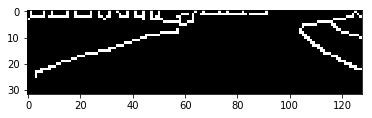

In [830]:
img = cv2.GaussianBlur(img, (5,5),1)
img = cv2.Canny(img, 100, 200)
plt.imshow(img,cmap='gray')

### Normalization
We don't perform normalization since the image is binary. 

## Load and Prep Pipeline
Note: the images are only a few hundred Mbytes in memory, so we won't use a generator. 

In [5]:
IMG_WIDTH = 128
IMG_HEIGHT = 32
def load_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)[64:128]
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT), cv2.INTER_CUBIC)
    img = cv2.GaussianBlur(img, (5,5),1)
    img = cv2.Canny(img, 100, 200)
    return img.astype(np.float32)[:,:,None]

In [810]:
data = pd.read_csv('./clean.csv')
data = shuffle(data)

In [811]:
y_data = data.angle.values.astype(np.float32)
x_data = np.empty((len(data.center), IMG_HEIGHT,IMG_WIDTH,1), dtype=np.float32)
for i in range(len(data)):
    x_data[i] = load_img(data.center.values[i]) 

print('total number of samples: ', len(x_data))
print('total number of labels: ', len(y_data))

total number of samples:  27456
total number of labels:  27456


## Model Architecture
Since we've chosen to do major reductions and simplifications of the data in preprocessing, our model is small and slim.

### Structure
The network is fully convolutional (except the output - for convinience). There are a total of 6 layers. Each convolutional layer is composed of 5x5 filters with same padding, l2 weight regularizer, and a RELU activation layer. The convolution is followed by an average pooling layer, dropout, and gaussian noise layers. The ADAM optimization algorithm is utilized to tune the learning rate. The error function is the Mean Squared Error.  

#### Rationale
1. _Fully Covnet_: its an appealing architecture due to its homogenous structure. 
2. _Average Pooling_: it helps minimize overfitting due to averaging out outliers.
3. _Noise + Dropout_: for this project, noise proved to be very beneficial since, likely since it makes it difficult to lock-on to any single feature.
4. _L2 Regularization_: puts an exponential penalty on kernel weights.
5. _ADAM Optimizer_: Automagically tunes the learning rate during training, very effective.
6. _RELU_: enables learning non-linear data.
7. Most hyper parameter values were chosen by trial and error.


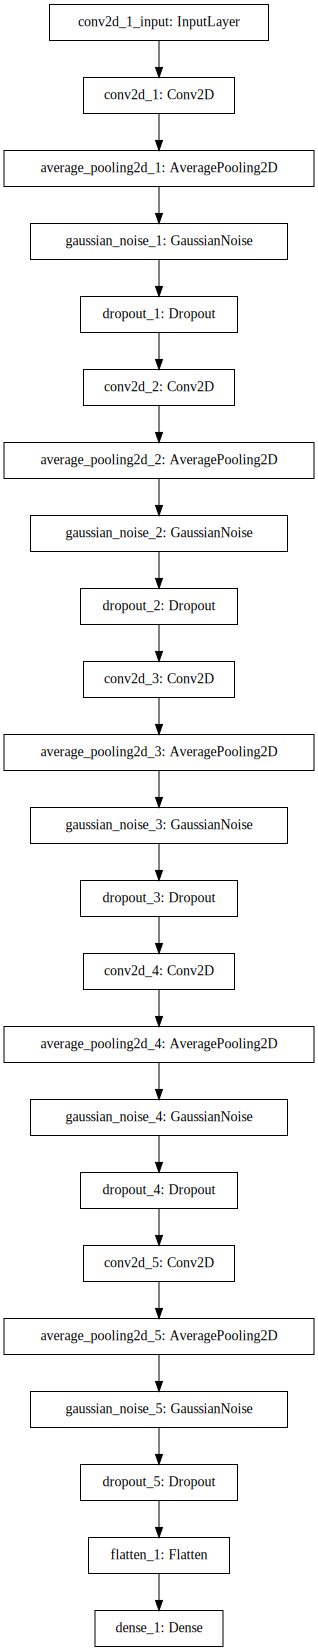

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
L2_PENALTY=0.001
DROPOUT_PROB = 0.1
NOISE_STDV = 0.1

In [8]:
# del model
# K.clear_session()

model = Sequential()
model.add(Conv2D(4, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), 
                 padding='same', activation='relu', kernel_regularizer=l2(L2_PENALTY)))
model.add(AvgPool2D())
model.add(GaussianNoise(stddev=NOISE_STDV))
model.add(Dropout(rate=DROPOUT_PROB))

model.add(Conv2D(8, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(L2_PENALTY)))
model.add(AvgPool2D())
model.add(GaussianNoise(stddev=NOISE_STDV))
model.add(Dropout(rate=DROPOUT_PROB))

model.add(Conv2D(16, (5, 5),padding='same', activation='relu', kernel_regularizer=l2(L2_PENALTY)))
model.add(AvgPool2D())
model.add(GaussianNoise(stddev=NOISE_STDV))
model.add(Dropout(rate=DROPOUT_PROB))

model.add(Conv2D(8, (5, 5),padding='same', activation='relu', kernel_regularizer=l2(L2_PENALTY)))
model.add(AvgPool2D())
model.add(GaussianNoise(stddev=NOISE_STDV))
model.add(Dropout(rate=DROPOUT_PROB))

model.add(Conv2D(4, (5, 5),padding='same', activation='relu', kernel_regularizer=l2(L2_PENALTY)))
model.add(AvgPool2D())
model.add(GaussianNoise(stddev=NOISE_STDV))
model.add(Dropout(rate=DROPOUT_PROB))

model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 128, 4)        104       
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 64, 4)         0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 16, 64, 4)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 64, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 8)         808       
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 32, 8)          0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 8, 32, 8)          0         
__________

In [824]:
# train
model.fit(x_data, y_data, batch_size=64, epochs=16, verbose=2, validation_split=0.2)
print('Done Training')
# save
s=model.save('../model.h5',overwrite=True)
print('Model Saved', s)

Train on 21964 samples, validate on 5492 samples
Epoch 1/16
 - 9s - loss: 0.1240 - val_loss: 0.0380
Epoch 2/16
 - 8s - loss: 0.0625 - val_loss: 0.0322
Epoch 3/16
 - 8s - loss: 0.0497 - val_loss: 0.0280
Epoch 4/16
 - 8s - loss: 0.0423 - val_loss: 0.0284
Epoch 5/16
 - 8s - loss: 0.0370 - val_loss: 0.0235
Epoch 6/16
 - 8s - loss: 0.0324 - val_loss: 0.0208
Epoch 7/16
 - 8s - loss: 0.0292 - val_loss: 0.0192
Epoch 8/16
 - 8s - loss: 0.0264 - val_loss: 0.0188
Epoch 9/16
 - 8s - loss: 0.0237 - val_loss: 0.0162
Epoch 10/16
 - 8s - loss: 0.0216 - val_loss: 0.0148
Epoch 11/16
 - 8s - loss: 0.0195 - val_loss: 0.0139
Epoch 12/16
 - 8s - loss: 0.0177 - val_loss: 0.0124
Epoch 13/16
 - 8s - loss: 0.0164 - val_loss: 0.0113
Epoch 14/16
 - 8s - loss: 0.0152 - val_loss: 0.0105
Epoch 15/16
 - 8s - loss: 0.0143 - val_loss: 0.0108
Epoch 16/16
 - 8s - loss: 0.0135 - val_loss: 0.0096
Done Training
Model Saved None


### Handle Model Persistence

array([[-0.28289846]], dtype=float32)

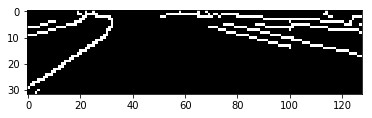

In [389]:
plt.imshow(x_data[0,:,:,0],cmap='gray')
model.predict(x_data[None,0,:,:,:],batch_size=1)

## Results
The model performs relatively well considering how small it is (e.g 1/32 the size of Nvidia's). However, its size is a compromise since a lot of pre-processing is required and the result is very fragile.

### Shadows
Shadows are hard to differentiate in grayscale, especially after edge detection. It's a though problem, one possible direction to a solution is converting to HSI, then interpolating to a monotone - shadows are mostly visible in the I channel since they have little effect color tone and saturation.